# Speech Commands recognition using ConvNets in PyTorch (Tutorial)

This is a tutorial post on speech commands recognition using the [Speech Commands dataset](https://arxiv.org/abs/1804.03209). The goals for this post  

1. Work with audio data using torchaudio: look at spectrograms features and data augmentation
2. Train a model to recogize audio data from a vocabulary of spoken commands
3. Evaluate model performance using measures like accuracy (error rate) and confusion matrix

There are around 10 speech commands like Yes, No, Up, Down and so on. The dataset contains wav files sampled at 16000 Hz and each command waveform contains upto a second of data. In addition to the commands themselves, there are some words that are not commands (and phonetically diverse) and background files containing background noise and silence segments. 

We will rely heavily on the torchaudio package for input preprocessing. It has some convenient dataloaders and feature preprocessing transforms. The nice thing about torchaudio, is that the feature processing can take place on the GPU and this will accelerate the training process significantly. 

To install torchaudio, the command below should be executed in a terminal:  
conda install -c pytorch torchaudio

The -c option searches on the pytorch channel.  

This notebook is available on github at this [link].(https://github.com/jumpml/pytorch-tutorials/blob/master/SpeechCommands_CNN.ipynb)

In [1]:
# CUSTOMARY IMPORTS
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from jumpml import SpeechCommandsDataset as scd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
%matplotlib inline

random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

True

## Data  Setup

We have created a wrapper around torchaudio's SPEECHCOMMANDS dataset class. The wrapper performs the following steps for us  
1. Create train, val and test splits of the dataset 
2. Process the background noise files and creates 1 sec segments for augmenting each split
3. Pad the data to 1s and map the string labels to integer. Number 11 corresponds to background or unknown. 
4. Creates dataloaders for each split with appropriate transforms (MelSpectrogram, etc.)

The torchaudio class automatically downloads the data if not already on disk. If we look at the source code for the speechcommands dataset class in torchaudio, we need to specify the version of speech commands (v0.2). The dataset is around 2.3GB in size. Each item in the dataloader consists of the following information:  
waveform, sample_rate, label, speaker_id, utterance_number. 

In this tutorial, we are not using speaker_id or utterance_number. We are not downsampling the audio to 8kHz, which may be a good thing to do, since it is an effective way to throw away information that is not related to the task of recognizing commands. Most of the voice information is between 20 Hz to 3.6 kHz. 

### Feature Pre-Processing
Torchaudio comes with optimized several useful [transforms](https://pytorch.org/audio/transforms.html), which we can use to get our input features efficiently computed on GPU. 

Here is the feature processing we use for training data
```python
self.train_transform = torch.nn.Sequential(
   torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=320, hop_length=160, n_mels=n_mels),
   torchaudio.transforms.FrequencyMasking(freq_mask_param=int(n_mels*0.2)),
   torchaudio.transforms.TimeMasking(time_mask_param=int(0.2 * 16000/160)),
   torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80))
```

A spectrogram is used to map the a waveform to a time-frequency representation which is almost always used in any kind of speech processing. We use a hop length of 10ms and a FFT size of 20 ms. In order to keep our inputs small, we also employ mel filterbanks to get 40 features in total. Then we convert the spectrogram magnitude to log-power scale in dB with a minimum floor of -80 dB. In order to get more general features, we apply Frequency and Time masking.



In [3]:
batch_size_train = 64
# Setup train, val and test dataloaders
sc_data = scd.SpeechCommandsData(train_bs=batch_size_train, test_bs=256, val_bs=256, n_mels=64)

Found existing background directory. Removing files in that directory.
Initialize/download SpeechCommandsDataset....

SpeechCommands Dataset Size: 105829

Generate 1s background files:

Background files generated: 220

Extracting training dataset files...
Train dataset extracted: 84843 files 

Extracting test and val dataset files...
Validation dataset extracted: 9981 files
Test dataset extracted: 11005 files


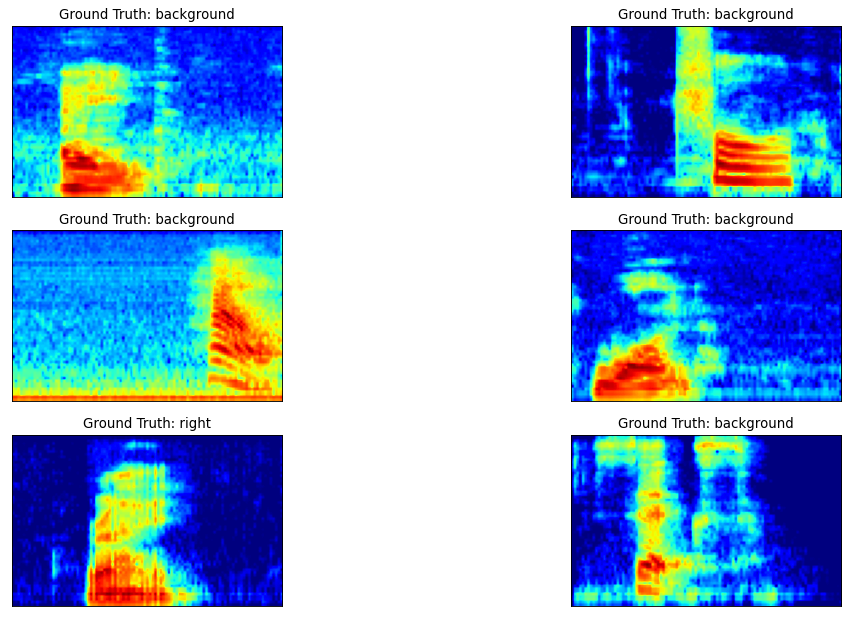

In [4]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(sc_data.test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(16, 8), dpi=80)
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(torch.squeeze(example_X[i]), cmap='jet', origin='lower')
  plt.title("Ground Truth: {}".format(scd.KNOWN_COMMANDS[int(example_y[i])]))
  plt.xticks([])
  plt.yticks([])

In [5]:
example_X.shape
freq_dim = int(example_X.shape[2])
time_dim = int(example_X.shape[3])

## Model Specification

The model we use is not too complicated:   
Input X (B,1,40,101)  
--> 32 Conv2D(8,20) --> BatchNorm2D --> MaxPool2D(2) --> ReLU  
--> 8 Conv2D(4,10)  --> BatchNorm2D --> MaxPool2D(2) --> ReLU  
--> Linear(128)     --> BatchNorm1D                  --> ReLU  
--> Linear(11)                                       --> LogSoftmax  


where B is Batch Size, the arguments to Conv2D are input numChannels, output numChannels and kernel size.

In [6]:
def get_conv_size(in_dim, kernel_size, stride=1, padding=0, dilation=1):
    return ( (in_dim + 2*padding - dilation * (kernel_size - 1) - 1) // stride  + 1)

In [7]:
input_size = (freq_dim,time_dim)    # Spectrogram has 40 x 101 input images
C1_kernel_size = (8,20) # Customary to use odd and square kernel/filter size fxf 
num_filters_conv1 = 32
num_filters_conv2 = 8
C2_kernel_size = (4,10) # Customary to use odd and square kernel/filter size fxf 
mp2d_size = 2      # MaxPooling2d window size (= stride)
fc1_out_size = 128
fc2_out_size = 11  # 10 commands and 1 background class

C1 = (get_conv_size(input_size[0], C1_kernel_size[0]), 
      get_conv_size(input_size[1], C1_kernel_size[1]))         # C1: size after conv1 
MP1 = (get_conv_size(C1[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C1[1], mp2d_size, stride = mp2d_size)) # MP1: size after max_pool2d
C2 = (get_conv_size(MP1[0], C2_kernel_size[0]),
       get_conv_size(MP1[1], C2_kernel_size[1]))               # C2: size after conv2 
MP2 = (get_conv_size(C2[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C2[1], mp2d_size, stride = mp2d_size)) # MP2: size after max_pool2d
fc1_in_size = MP2[0]*MP2[1] * num_filters_conv2                   # pixels * num_filters

print(f'C1:{C1} MP1:{MP1}   C2:{C2} MP2:{MP2}    FC1_in:{fc1_in_size}')

C1:(57, 82) MP1:(28, 41)   C2:(25, 32) MP2:(12, 16)    FC1_in:1536


In [8]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters_conv1, kernel_size=C1_kernel_size)
        self.bn1   = nn.BatchNorm2d(num_filters_conv1)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, C2_kernel_size)
        self.bn2   = nn.BatchNorm2d(num_filters_conv2)
        self.fc1 = nn.Linear(fc1_in_size, fc1_out_size)
        self.bn3   = nn.BatchNorm1d(fc1_out_size)
        self.fc2 = nn.Linear(fc1_out_size, fc2_out_size)           # number of classes = 11

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), mp2d_size))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), mp2d_size))
        x = x.view(-1, fc1_in_size)    # reshape
        x = F.relu(self.bn3(self.fc1(x)))
        #x = F.dropout(x, training=self.training)  # Apply dropout only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

nnModel = model().to(device)       # Instantiate our model and move model to GPU if available

In [9]:
model_parameters = filter(lambda p: p.requires_grad, nnModel.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Model size: {params} parameters' )

Model size: 213891 parameters


## Objective or Loss Function
In the model the final layer is a log-softmax function, in orderwords we get a vector of per-utterance log probabilities or log-likelihoods. So the output of the model is basically 
$$ \hat{y} = \log P(y | x) $$

If we combine this with the nll_loss, which stands for negative log-likelihood loss which basically does the following operation  
$$
l(\hat{y},y) = -\hat{y}[y]
$$

where $y$ is the true class label in ${0,1,...,C-1}$. If the model predicted the correct command with probability 1.0, then this loss would be 0.0. Otherwise it would be a positive number. By combining log-softmax and NLL loss, we get the Cross Entropy Loss. 

In [10]:
# Define objective function
lossFn = F.nll_loss  #When we combine nll_loss and log_softmax we get a cross entropy loss

## Model Optimization or Training 
The new parameters are the previous parameters with a step (proportional to learning rate $\mu$) in the direction (negative gradient of loss function w.r.t parameters) that reduces the loss function. In terms of math for a single labeled example $y$ and model prediction $\hat{y}$  
$$ W_n = W_{n-1} - \mu \nabla_{W} l(\hat{y},y) $$

For a batch of examples, we simply replace the loss above with some reduction such as the mean loss over the batch.

We will also apply **learning rate decay** on the initial learning rate. The StepLR function will apply a decay of $\gamma$ every step_size number of epochs to the exisiting learning rate in the optimizer. 


In [11]:
learning_rate = 0.1   # Learning rate for optimizer like SGD usually in [0.001, 0.1]
# Define optimization
optimizer = optim.SGD(nnModel.parameters(), lr=learning_rate, momentum=0.5)

# Apply decaying Learning Rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

## Mechanics of Training
Basically has the following steps which we repeat until all batches of training data are consumed
1. Get a batch of inputs (X) and corresponding labels (y), move to device
2. Initialize gradients
3. Calculate loss function on current batch of inputs and labels
4. Calculate gradients by calling backward() on the loss function output
5. Update parameters by calling optimizer.step()

At the start of end of each epoch (when one complete round of training data has been used), the learning rate is decayed. 

In [12]:
train_losses = []
TrainLen = len(sc_data.train_loader.dataset)
def train(model, lossFn, optimizer, train_loader, log_frequency=100):
  model.train()
  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    # Move to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Initialize gradients
    optimizer.zero_grad()
    # Predict on current batch of data
    y_hat = model(X_train)
    # Calculate Average Loss
    loss = lossFn(y_hat, y_train)
    # Calculate Gradients
    loss.backward()
    # Update model parameters using SGD
    optimizer.step()
    if batch_idx % log_frequency == 0:
      print(f'Train  {batch_idx * len(X_train)}/{TrainLen} Loss:{loss.item()}\n')
      train_losses.append(loss.item())
  
  scheduler.step() # update learning rate for next call to train()
  




In [14]:
def evalModel(model, lossFn, dataloader, losses, mode='Val'):
  model.eval()
  loss = 0
  correct = 0
  predictions = torch.tensor([])
  labels = torch.tensor([])
  with torch.no_grad():
    for X_test, y_test in dataloader:
      labels = torch.cat((labels, y_test),dim=0)
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_hat = model(X_test)
      loss += lossFn(y_hat, y_test).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      predictions = torch.cat((predictions, pred.cpu()),dim=0)
      correct += pred.eq(y_test.data.view_as(pred)).sum()
  loss /= len(dataloader.dataset)
  losses.append(loss)
  accuracy = 100. * correct / len(dataloader.dataset)
  print(f'\n{mode} set: Avg. loss: {loss:.4f}, Accuracy: {accuracy} %\n')
  cm = confusion_matrix(predictions.numpy(), labels.numpy())
  return(accuracy, cm)

## Let's Train

In [15]:
val_losses = []
n_epochs = 50
val_accuracy = np.zeros(n_epochs+1)
log_frequency=100
val_accuracy[0],_ = evalModel(nnModel, lossFn, sc_data.val_loader, val_losses)
for epoch in range(1, n_epochs + 1):
  print(f'Epoch-{epoch} lr: {optimizer.param_groups[0]["lr"]}')
  train(nnModel, lossFn, optimizer, sc_data.train_loader,log_frequency)
  val_accuracy[epoch],_ = evalModel(nnModel, lossFn, sc_data.val_loader, val_losses)
  
  


Val set: Avg. loss: 0.0133, Accuracy: 3.819617986679077 %

Epoch-1 lr: 0.1
Train  0/85019 Loss:2.7619423866271973

Train  6400/85019 Loss:0.9802383184432983

Train  12800/85019 Loss:1.326415777206421

Train  19200/85019 Loss:1.128999948501587

Train  25600/85019 Loss:0.7955763339996338

Train  32000/85019 Loss:0.6850683093070984

Train  38400/85019 Loss:0.9072615504264832

Train  44800/85019 Loss:0.7251432538032532

Train  51200/85019 Loss:0.6652300953865051

Train  57600/85019 Loss:0.6656129360198975

Train  64000/85019 Loss:0.74540776014328

Train  70400/85019 Loss:0.64520663022995

Train  76800/85019 Loss:0.8235475420951843

Train  83200/85019 Loss:0.8623945713043213


Val set: Avg. loss: 0.0016, Accuracy: 86.79132080078125 %

Epoch-2 lr: 0.1
Train  0/85019 Loss:0.8678790926933289

Train  6400/85019 Loss:0.6692460775375366

Train  12800/85019 Loss:0.6700356006622314

Train  19200/85019 Loss:0.5217165946960449

Train  25600/85019 Loss:0.4669366180896759

Train  32000/85019 Loss:0.56

Train  76800/85019 Loss:0.1521443873643875

Train  83200/85019 Loss:0.20910972356796265


Val set: Avg. loss: 0.0007, Accuracy: 94.71052551269531 %

Epoch-13 lr: 0.00625
Train  0/85019 Loss:0.14748957753181458

Train  6400/85019 Loss:0.2412066012620926

Train  12800/85019 Loss:0.18191562592983246

Train  19200/85019 Loss:0.22166188061237335

Train  25600/85019 Loss:0.2675594389438629

Train  32000/85019 Loss:0.21410641074180603

Train  38400/85019 Loss:0.24491314589977264

Train  44800/85019 Loss:0.2955782115459442

Train  51200/85019 Loss:0.1902703493833542

Train  57600/85019 Loss:0.2806141674518585

Train  64000/85019 Loss:0.427950918674469

Train  70400/85019 Loss:0.3325624167919159

Train  76800/85019 Loss:0.23031723499298096

Train  83200/85019 Loss:0.235918328166008


Val set: Avg. loss: 0.0007, Accuracy: 94.66053009033203 %

Epoch-14 lr: 0.00625
Train  0/85019 Loss:0.18694588541984558

Train  6400/85019 Loss:0.1205553412437439

Train  12800/85019 Loss:0.2087802141904831

Train 

Train  51200/85019 Loss:0.1382126808166504

Train  57600/85019 Loss:0.15068310499191284

Train  64000/85019 Loss:0.31326353549957275

Train  70400/85019 Loss:0.25312739610671997

Train  76800/85019 Loss:0.2682033181190491

Train  83200/85019 Loss:0.1926046907901764


Val set: Avg. loss: 0.0007, Accuracy: 94.88050842285156 %

Epoch-25 lr: 0.000390625
Train  0/85019 Loss:0.16882801055908203

Train  6400/85019 Loss:0.42971286177635193

Train  12800/85019 Loss:0.14271610975265503

Train  19200/85019 Loss:0.16873472929000854

Train  25600/85019 Loss:0.23520778119564056

Train  32000/85019 Loss:0.30092155933380127

Train  38400/85019 Loss:0.29654258489608765

Train  44800/85019 Loss:0.2288070172071457

Train  51200/85019 Loss:0.3142462968826294

Train  57600/85019 Loss:0.14746025204658508

Train  64000/85019 Loss:0.2503327429294586

Train  70400/85019 Loss:0.20095206797122955

Train  76800/85019 Loss:0.12046511471271515

Train  83200/85019 Loss:0.16734817624092102


Val set: Avg. loss: 0.000

Train  70400/85019 Loss:0.25633010268211365

Train  76800/85019 Loss:0.2780078649520874

Train  83200/85019 Loss:0.2672208845615387


Val set: Avg. loss: 0.0007, Accuracy: 94.97050476074219 %

Epoch-38 lr: 6.103515625e-06
Train  0/85019 Loss:0.15416669845581055

Train  6400/85019 Loss:0.198228120803833

Train  12800/85019 Loss:0.27705031633377075

Train  19200/85019 Loss:0.14358867704868317

Train  25600/85019 Loss:0.2771683633327484

Train  32000/85019 Loss:0.2817661762237549

Train  38400/85019 Loss:0.2008223533630371

Train  44800/85019 Loss:0.3773912787437439

Train  51200/85019 Loss:0.3963407874107361

Train  57600/85019 Loss:0.19908729195594788

Train  64000/85019 Loss:0.11452803015708923

Train  70400/85019 Loss:0.2886974811553955

Train  76800/85019 Loss:0.18709932267665863

Train  83200/85019 Loss:0.3121488392353058


Val set: Avg. loss: 0.0007, Accuracy: 94.93050384521484 %

Epoch-39 lr: 6.103515625e-06
Train  0/85019 Loss:0.260833203792572

Train  6400/85019 Loss:0.076804913

Train  25600/85019 Loss:0.20683616399765015

Train  32000/85019 Loss:0.17986440658569336

Train  38400/85019 Loss:0.2823738157749176

Train  44800/85019 Loss:0.1694626659154892

Train  51200/85019 Loss:0.15147116780281067

Train  57600/85019 Loss:0.25429168343544006

Train  64000/85019 Loss:0.2587723433971405

Train  70400/85019 Loss:0.30226436257362366

Train  76800/85019 Loss:0.20562075078487396

Train  83200/85019 Loss:0.16101430356502533


Val set: Avg. loss: 0.0007, Accuracy: 94.82051849365234 %

Epoch-50 lr: 3.814697265625e-07
Train  0/85019 Loss:0.2582589387893677

Train  6400/85019 Loss:0.19503077864646912

Train  12800/85019 Loss:0.22071579098701477

Train  19200/85019 Loss:0.3284406363964081

Train  25600/85019 Loss:0.10867908596992493

Train  32000/85019 Loss:0.20627374947071075

Train  38400/85019 Loss:0.24131649732589722

Train  44800/85019 Loss:0.2952113151550293

Train  51200/85019 Loss:0.3117126524448395

Train  57600/85019 Loss:0.22171467542648315

Train  64000/85019 L

## Performance Evaluation
The train dataset was used to train the model. The validation dataset is used to see if our model is overfitting or not over epochs. The test set is only gets used once at the end of model training and any architecture or hyperparameter optimization. 


Text(0, 0.5, 'negative log likelihood loss')

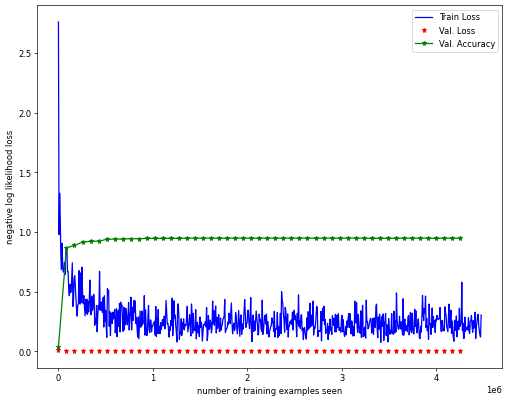

In [16]:
fig=plt.figure(figsize=(10, 8), dpi=60)
x = range(0,log_frequency*len(train_losses)*batch_size_train,log_frequency*batch_size_train)
plt.plot(x, train_losses, color='blue')
x = range(0, TrainLen*len(val_losses), TrainLen)
plt.plot(x,val_losses,'r*')
plt.plot(x,np.array(val_accuracy)/100.0,'g*-')
plt.legend(['Train Loss', 'Val. Loss', 'Val. Accuracy'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

As usual we will evaluate performance using accuracy rate, i.e. how many commands do we get correct on average. Another useful metric to look at is the confusion matrix, which tells us about how the model makes errors, when it makes errors. 

In [17]:
test_loss = []
accuracy, cm = evalModel(nnModel, lossFn, sc_data.test_loader, test_loss)
print(f'Test set accuracy = {accuracy}')
print(cm)


Val set: Avg. loss: 0.0007, Accuracy: 94.42277526855469 %

Test set accuracy = 94.42277526855469
[[ 393    0    0    2    6    0    0    0    0    1    4]
 [   0  357    0   17    0    0    0    0    0   16   23]
 [   0    3  390    0    1    0    1   14    4    2   15]
 [   0    3    0  336    0    0    0    0    0    5   11]
 [   3    0    0    1  369    1    0    0    0    1   22]
 [   0    0    0    0    2  360    0    0    0    0   16]
 [   0    0    2    0    0    0  337    9    0    0   24]
 [   0    0    6    0    0    0   14  353    1    1   16]
 [   0    0    3    1    0    0    0    1  393    1    8]
 [   0    7    0   10    0    0    2    3    0  329   19]
 [  23   35   24   39   34   35   42   22   13   46 6795]]


In [18]:
# Got this function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 393    0    0    2    6    0    0    0    0    1    4]
 [   0  357    0   17    0    0    0    0    0   16   23]
 [   0    3  390    0    1    0    1   14    4    2   15]
 [   0    3    0  336    0    0    0    0    0    5   11]
 [   3    0    0    1  369    1    0    0    0    1   22]
 [   0    0    0    0    2  360    0    0    0    0   16]
 [   0    0    2    0    0    0  337    9    0    0   24]
 [   0    0    6    0    0    0   14  353    1    1   16]
 [   0    0    3    1    0    0    0    1  393    1    8]
 [   0    7    0   10    0    0    2    3    0  329   19]
 [  23   35   24   39   34   35   42   22   13   46 6795]]


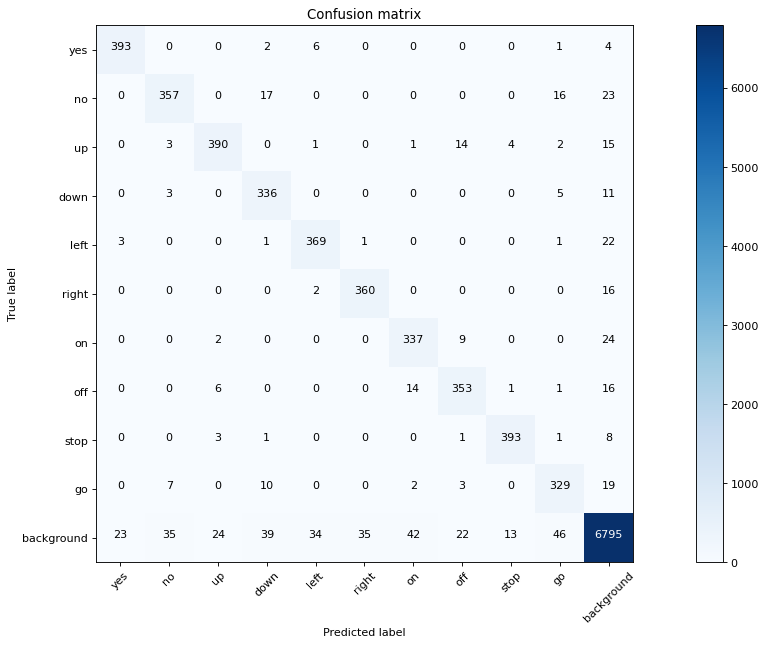

In [19]:
fig=plt.figure(figsize=(16, 8), dpi=80)
plot_confusion_matrix(cm, scd.KNOWN_COMMANDS)

In [21]:
# Save Model
# Specify a path
PATH = "./models/speech_commands_model.pt"

# Save
torch.save(nnModel.state_dict(), PATH)